# Project: Detecting Fraud in Job Postings

Data Source: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

### Problem Statement:
* A company has requested a predictive model that can detect whether job postings are legitimate or fraudulent. Concerns have been raised from recruiters, advertisers, and subscription-based members about fraudulent job postings that undermine the reputation of the company’s services.

### Key Metric:
* Recall of the minority class (minimizing false negatives)

### Methods:

Oversampling minority class:
* The classes for the target variable were not only very imbalanced (fraudulent job postings <5% of the data), but there were very few records for fraudulent job postings in total (856). Synthetic oversampling of the minority class was completed via SMOTE. 

Naive Bayes:
* Complement Naive Bayes was chosen for its relative strength in both text classification and imbalanced datasets. The optimal smoothing parameter was tuned via GridSearchCV.

Natural language processing:
* Numeric features were created from the five text columns using NLTK. Additional natural language processing was considered but ultimately rejected; further tokenization/lemmatization/stemming to standardize the text could inadvertently compromise features from the text that actually predict fraud (ex. inflectional irregularities may be more frequent in fraudulent job postings, etc.) and understanding the meaning of the text was not required for the problem statement. Text columns were combined and transformed using the TFIDF Vectorizer (with accents and stop words removed), chosen because frequency is likely an important factor for fraud detection. 

### Model Performance:
* Key metric (recall of the minority class): 87%
* Overall accuracy: 94%


In [4]:
#load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import recall_score, classification_report, make_scorer, confusion_matrix, roc_curve, roc_auc_score

## Data Wrangling and Exploratory Data Analysis

In [5]:
#load data
data = pd.read_csv('job_postings.csv', index_col=0)

In [6]:
#check data load
data.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [7]:
#check general information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

* Many null values for several explanatory variables
* No null values for the target variable 'fraudulent'
* Categorical and text variables only, no numeric variables

In [8]:
#check for duplicates
data.duplicated().sum()

281

In [9]:
#drop duplicates
df = pd.DataFrame(data.drop_duplicates())

In [10]:
#check target variable classes
df.fraudulent.value_counts()

0    16743
1      856
Name: fraudulent, dtype: int64

* Very imbalanced classes
* Very few data points for the minority class

In [11]:
#check null value percentages 
(round(df.isnull().sum()/len(df)*100, 2)).sort_values(ascending=False)

salary_range           83.94
department             64.37
required_education     45.51
benefits               40.38
required_experience    39.56
function               36.16
industry               27.48
employment_type        19.48
company_profile        18.65
requirements           15.05
location                1.94
description             0.01
title                   0.00
telecommuting           0.00
has_questions           0.00
has_company_logo        0.00
fraudulent              0.00
dtype: float64

* Simple imputation strategies will be avoided in order to retain as much information as possible for the extremely small minority class

### Categorical Variables

In [12]:
#check salary_range column
df.salary_range.value_counts()

0-0            141
40000-50000     66
30000-40000     54
45000-67000     36
25000-30000     36
              ... 
60-75            1
27500-36000      1
20-22            1
110-120          1
3700-3800        1
Name: salary_range, Length: 874, dtype: int64

* 84% missing values
* Inconsistent ranges, perhaps due to hourly/annual salary differences
* Any distribution based on actual salary value will likely not be relevant
* However, fraud may be predicted by a 'fake' salary range
* Convert to a boolean variable

In [13]:
#create has_salary column to replace salary_range
df['has_salary'] = df.salary_range.notnull().astype('int')

#drop salary_range column
df.drop(columns=['salary_range'], inplace=True)

In [14]:
#check required_education
df.required_education.value_counts()

Bachelor's Degree                    5099
High School or equivalent            1989
Unspecified                          1369
Master's Degree                       416
Associate Degree                      264
Certification                         165
Some College Coursework Completed     100
Professional                           73
Vocational                             47
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

* 'Unspecified' column already exists
* Multiple 'Vocational' values

In [15]:
#fill missing values with 'Unspecified'
df.required_education.fillna('Unspecified', inplace=True)

In [16]:
#consolidate vocational values
df.required_education.replace(to_replace=['Vocational - HS Diploma','Vocational - Degree'], value='Vocational', inplace=True)


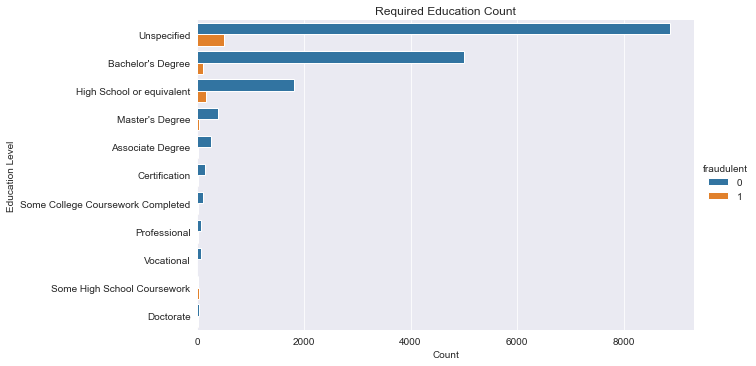

In [17]:
#check distribution of education
order = df.required_education.value_counts().index
sns.set_style("darkgrid")
sns.catplot(y='required_education', data=df, order=order, kind='count', orient='h', aspect=2, hue='fraudulent')
plt.title('Required Education Count')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.show()

* For both classes, many 'Unspecified' required education values
* Fraudulent job postings target 'High School or equivalent' more than 'Bachelors'

In [18]:
#check required_experience
df.required_experience.value_counts()

Mid-Senior level    3768
Entry level         2637
Associate           2267
Not Applicable      1070
Director             383
Internship           372
Executive            140
Name: required_experience, dtype: int64

* 'Not Applicable' may mean no experience is required
* Fill missing values with 'Unspecified' to be consistent with education_required values 

In [19]:
#fill missing values with 'Unspecified'
df.required_experience.fillna('Unspecified', inplace=True)

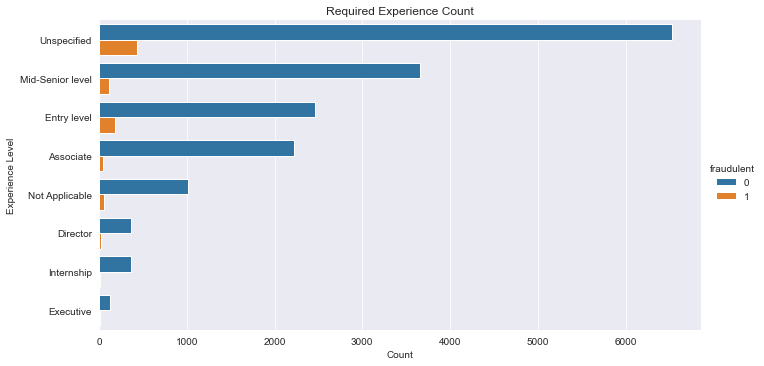

In [20]:
#check distribution of required_experience
order = df.required_experience.value_counts().index
sns.catplot(y='required_experience', data=df, order=order, kind='count', orient='h', aspect=2, hue='fraudulent')
plt.title('Required Experience Count')
plt.xlabel('Count')
plt.ylabel('Experience Level')
plt.show()

* Again, majority for both classes 'Unspecified'
* Fraudulent job postings target 'Entry level' more than 'Mid-Senior level'

In [21]:
#check employment_type
df.employment_type.value_counts()

Full-time    11423
Contract      1514
Part-time      772
Temporary      237
Other          225
Name: employment_type, dtype: int64

In [22]:
#fill missing values with 'Unspecified'
df.employment_type.fillna('Unspecified', inplace=True)

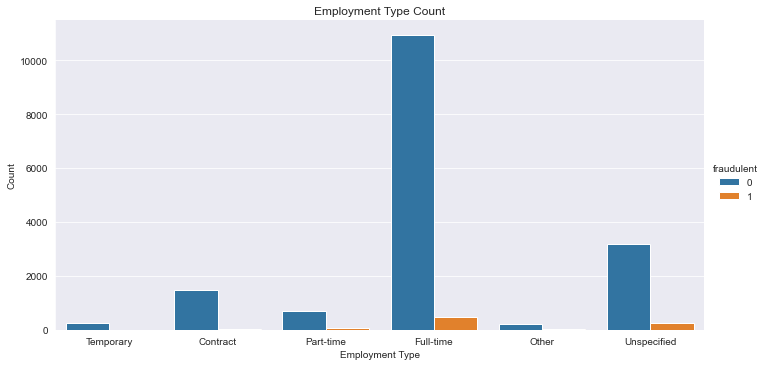

In [23]:
#check distribution of employment_type
order=['Temporary','Contract','Part-time','Full-time','Other','Unspecified']
sns.catplot(x='employment_type', data=df, order=order, kind='count', aspect=2, hue='fraudulent')
plt.title('Employment Type Count')
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.show()

In [24]:
#check location
df.location.value_counts()

GB, LND, London             718
US, NY, New York            644
US, CA, San Francisco       466
GR, I, Athens               462
US, ,                       339
                           ... 
GB, , Bedford                 1
IL, JM, Jerusalem             1
US, MI, Marcellus Lawton      1
ZA, GT, Four Ways             1
GB, WSX, Chichester           1
Name: location, Length: 3105, dtype: int64

* Location can be separated out into three separate columns: country, state, city

### Geographical Variables

In [25]:
#create country column
df['country'] = df.location.str.split(',').str[0]
print(df.country.nunique())
df.country.value_counts()

90


US    10460
GB     2329
GR      938
CA      450
DE      382
      ...  
SI        1
PE        1
SD        1
UG        1
KH        1
Name: country, Length: 90, dtype: int64

In [26]:
#check missing values
df.country.isnull().sum()

341

In [27]:
#fill missing values with 'Unspecified'
df.country.fillna('Unspecified', inplace=True)

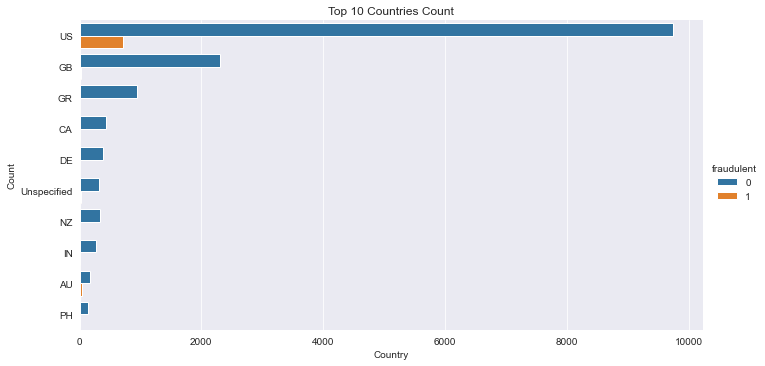

In [28]:
#check distribution of top 10 countries
order = df.country.value_counts().head(10).index
sns.catplot(y='country', data=df, order=order, kind='count', orient='h', aspect=2, hue='fraudulent')
plt.title('Top 10 Countries Count')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

* Majority of job postings overall in the US
* Fraudulent job postings almost exclusively in the US

In [29]:
#create state column
df['state'] = df.location.str.split(',').str[1]
print(df.state.nunique())
df.state.value_counts()

325


        2108
 CA     2012
 NY     1228
 LND     991
 TX      957
        ... 
 ENF       1
 D         1
 061       1
 82        1
 NLE       1
Name: state, Length: 325, dtype: int64

* Some countries may not refer to sub-regions as 'states' and may instead refer to them by a numeric code
* Numeric strings within the 'state' columns will be left as-is

In [30]:
#check missing values
df.state.isnull().sum()

432

In [31]:
#fill missing values with 'Unspecified'
df.state.fillna('Unspecified', inplace=True)

In [32]:
#create city column
df['city'] = df.location.str.split(',').str[2]

#lowercase and trim whitespace
df.city = df.city.str.lower().str.strip()

print(df.city.nunique())
df.city.value_counts()

2026


                     1620
london               1101
new york              685
athens                558
san francisco         488
                     ... 
perth and kinross       1
ridgewood               1
gaffney                 1
ahens                   1
berkeley heights        1
Name: city, Length: 2026, dtype: int64

* Some values are misentered (incorrect spelling, entered state instead of city)
* Errors may be indicative of fraud and will be left as-is

In [33]:
#check missing values
df.city.isnull().sum()

432

In [34]:
#fill missing values with 'Unspecified'
df.city.fillna('Unspecified', inplace=True)

In [35]:
#drop location column
df.drop(columns=['location'], inplace=True)

### Overlapping Variables

In [36]:
#department unique values and top 10 values``
print('total unique departments: ', df.department.nunique())
print('top 10 departments:')
print(df.department.value_counts().head(10))

total unique departments:  1337
top 10 departments:
Sales                     541
Engineering               483
Marketing                 397
Operations                266
IT                        224
Development               146
Product                   112
Information Technology     86
Design                     76
Technology                 75
Name: department, dtype: int64


* Inconsistency in categorization (ex. IT vs Information Technology, tech VS Technology)

In [37]:
#function unique values and top 10 values``
print('total unique functions: ', df.function.nunique())
print('top 10 functions:')
print(df.function.value_counts().head(10))

total unique functions:  37
top 10 functions:
Information Technology    1730
Sales                     1448
Engineering               1339
Customer Service          1180
Marketing                  818
Administrative             613
Design                     336
Health Care Provider       326
Other                      325
Education                  325
Name: function, dtype: int64


* Categorized more consistently than 'department'

In [38]:
#industry unique values and top 10 values``
print('total unique industries: ', df.industry.nunique())
print('top 10 industries:')
print(df.industry.value_counts().head(10))

total unique industries:  131
top 10 industries:
Information Technology and Services    1711
Computer Software                      1362
Internet                               1054
Education Management                    819
Marketing and Advertising               818
Financial Services                      748
Hospital & Health Care                  483
Consumer Services                       348
Telecommunications                      326
Oil & Energy                            286
Name: industry, dtype: int64


* Of the three, 'department' has by far the most missing values (~65%) and is the least consistently categorized (1337 unique values)
* The remaining two have fewer missing values: 'function' (36%) and 'industry' (27%), and are relatively more consistently categorized: 'function' (37 unique values) and 'industry' (131 unique values)
* Drop the 'department' column, keep 'function' and 'industry'

In [39]:
#drop department
df.drop(columns=['department'], inplace=True)

In [40]:
#fill missing values with 'Unspecified'
df.function.fillna('Unspecified', inplace=True)
df.industry.fillna('Unspecified', inplace=True)

### Numeric Variables from Text

* Basic numeric features will be created from the text before the text is transformed during vectorization 
* TFIDF analysis will be done after the train/test split to prevent data leakage

In [41]:
#create list of text variables
text = ['title','company_profile','description','requirements','benefits']

In [42]:
#create title character count variable
df['title_char'] = df.title.apply(len)

In [43]:
#function for word count
def word_count(text):
    return len(text.split())

In [44]:
#combine all text
df['combined_text'] = df[text].apply(lambda x: ' '.join(x.values.astype(str)), axis=1)

#drop other text columns
df.drop(columns=text, axis=1, inplace=True)

In [45]:
#create total word count variable
df['total_word'] = df.combined_text.astype('str').apply(word_count)

In [46]:
#function for sentence count
def sent_count(text):
    return len(sent_tokenize(text))

In [47]:
#create total sentence count
df['total_sent'] = df.combined_text.astype('str').apply(sent_count)

In [48]:
#create average words per sentence
df['avg_words_sent'] = df['total_word']/df['total_sent']

In [49]:
#define numeric variable list
numeric = ['title_char','total_word','total_sent','avg_words_sent']

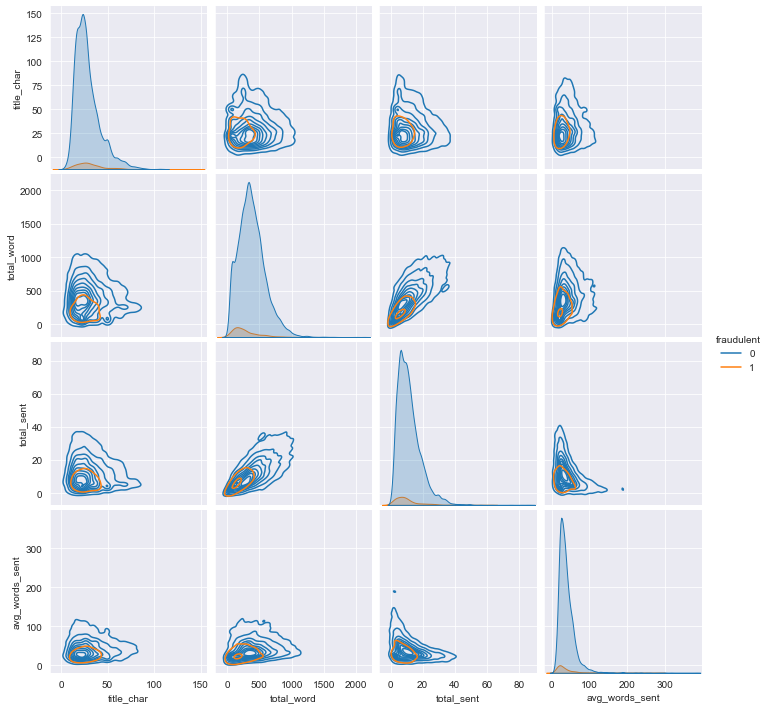

In [47]:
#check pair plots
sns.pairplot(data=df, vars=numeric, hue='fraudulent', kind='kde')
plt.show()

* In general, it looks like fraudulent job postings tend to stay in a shorter range
* Distributions indicate numeric variables will need to be scaled during preprocessing 

### Target Variable

In [50]:
#check class imbalance percentage
print('% of fraudulent job postings: ', round(df.fraudulent.sum()/len(df.fraudulent)*100, 2))

% of fraudulent job postings:  4.86


* The 'fraudulent' class is less than 5% of the data
* Because the key metric is recall, the minority class can by oversampled synthetically during preprocessing

In [51]:
#define target variable
y = df.fraudulent
X = df.drop('fraudulent', axis=1)

## Preprocessing

In [52]:
#define variable lists by type
numeric = X.select_dtypes(['int','float']).columns.tolist()
categorical = [column for column in X.columns if column not in numeric and column != 'combined_text']

In [53]:
#create pre-processor for variable types
processor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(strip_accents='unicode', stop_words='english'), 'combined_text'),
    ('number', MinMaxScaler(), numeric),
    ('category', OneHotEncoder(handle_unknown='ignore'), categorical)])

In [54]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=14)

## Modeling

In [92]:
#create model using imblearn pipeline for pre-processing, over-sampling, and the classifier
model = Pipeline(steps=[
    ['processor', processor],
    ['oversampling', SMOTE(random_state=14)],
    ['feature_selection', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear'))],
    ['classifier', ComplementNB()] 
])

In [93]:
#fit model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'combined_text'),
                                                 ('number', MinMaxScaler(),
                                                  ['telecommuting',
                                                   'has_company_logo',
                                                   'has_questions',
                                                   'has_salary', 'title_char',
                                                   'total_word', 'total_sent',
                                                   'avg_words_sent']),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),


In [94]:
#make predictions on both train and test sets
training_pred = model.predict(X_train)
testing_pred = model.predict(X_test)

In [95]:
#check classification reports
training_report = classification_report(y_train, training_pred)
testing_report = classification_report(y_test, testing_pred)
print('training classification report:')
print(training_report)
print('testing classification report:')
print(testing_report)

training classification report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     13394
           1       0.29      0.91      0.44       685

    accuracy                           0.89     14079
   macro avg       0.64      0.90      0.69     14079
weighted avg       0.96      0.89      0.91     14079

testing classification report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3349
           1       0.25      0.85      0.39       171

    accuracy                           0.87      3520
   macro avg       0.62      0.86      0.66      3520
weighted avg       0.96      0.87      0.90      3520



* Strong out-of-the-box performance by Complement Naive Bayes for the key metric: recall of the minority class (0.87)
* Precision of the minority class is lower than recall but is also not as relevant to the problem statement
* Additional models will not be considered; instead, hyperparameter tuning of the Complement Naive Bayes

In [131]:
sum(model['feature_selection'].get_support())

477

In [132]:
features = model['processor'].get_feature_names_out().ravel()
type(features)

numpy.ndarray

In [133]:
importances = np.abs(model['feature_selection'].estimator_.coef_.ravel())
type(importances)

numpy.ndarray

In [142]:
feature_imps = pd.DataFrame(zip(features, importances), columns=['features','importances'])

In [154]:
feature_imps_sorted = feature_imps.sort_values(by='importances',ascending=False).head(10)

In [147]:
feature_imps_sorted.head(10)

,features,importances
2314,text__accion,22.389753
71140,text__signing,21.761562
6253,text__aptitude,19.889383
15591,text__companies,19.075263
74892,text__sti,18.717262
71103,text__sigma,18.399697
14072,text__clearmark,16.588909
50921,text__novation,16.300921
56000,text__phone_0814f032f01156c9557f6d4239ae10ac57...,15.894445
30932,text__fiit,15.644814


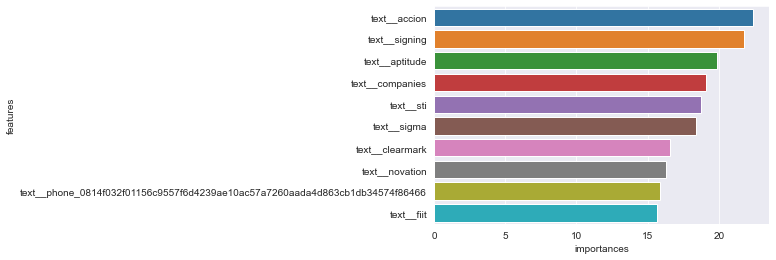

In [155]:
sns.barplot(y='features', x='importances', data=feature_imps_sorted, orient='h')

plt.show()

### Hyperparameter Tuning

* Attempt to find optimal smoothing parameter to further increase recall of the minority class

In [57]:
#make scorer for the key metric: recall of the minority class
scorer = make_scorer(recall_score, labels=[1], average=None)

In [58]:
#create param grid to test smoothing parameter--how much to adjust zero probability values in test set
param_grid = {
    'classifier__alpha': np.linspace(0.1, 1, 10),
    'feature_selection__estimator__c': [0.01, 0.1, 1]}

In [59]:
#run grid search to optimize recall of the minority class
grid_cv = GridSearchCV(model, param_grid=param_grid, cv=5, scoring=scorer)

In [60]:
#train grid search
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(stop_words='english',
                                                                                         strip_accents='unicode'),
                                                                         'combined_text'),
                                                                        ('number',
                                                                         MinMaxScaler(),
                                                                         ['telecommuting',
                                                                          'has_company_logo',
                                                                          'has_questions',
                                                                          'has_sal

In [61]:
#check best smoothing parameter
grid_cv.best_params_

{'classifier__alpha': 0.9}

In [62]:
#check range of mean test scores
grid_cv.cv_results_['mean_test_score']

array([0.84233577, 0.86423358, 0.86861314, 0.87737226, 0.88029197,
       0.88029197, 0.88029197, 0.87883212, 0.88175182, 0.88029197])

* Test scores stabilized around 0.88
* Additional values in the smoothing parameter not likely to increase model performance

In [63]:
#make predictions from the best estimator for additional metrics
grid_train_pred = grid_cv.predict(X_train)
grid_test_pred = grid_cv.predict(X_test)

In [64]:
#check classification reports
grid_train_report = classification_report(y_train, grid_train_pred)
grid_test_report = classification_report(y_test, grid_test_pred)
print('training classification report:')
print(grid_train_report)
print('testing classification report:')
print(grid_test_report)

training classification report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     13394
           1       0.54      0.98      0.70       685

    accuracy                           0.96     14079
   macro avg       0.77      0.97      0.84     14079
weighted avg       0.98      0.96      0.96     14079

testing classification report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3349
           1       0.46      0.87      0.60       171

    accuracy                           0.94      3520
   macro avg       0.72      0.91      0.78      3520
weighted avg       0.97      0.94      0.95      3520



* Only slight improvements in precision and f1-score (not recall) compared to previous model

In [65]:
#check confusion matrices
training_matrix = confusion_matrix(y_train, grid_train_pred)
testing_matrix = confusion_matrix(y_test, grid_test_pred)
print('training confusion matrix:')
print(training_matrix)
print('testing confusion matrix: ')
print(testing_matrix)

training confusion matrix:
[[12821   573]
 [   14   671]]
testing confusion matrix: 
[[3173  176]
 [  23  148]]


* Only 23 fraudulent job postings were missed (misclassified as legitimate) in the test set
* Model performance was likely affected but unseen text values, though a higher smoothing parameter value (0.9) has helped

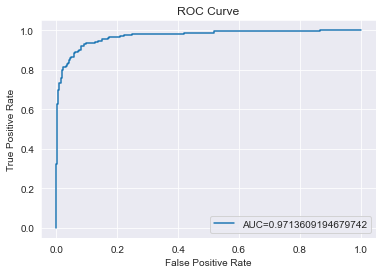

In [66]:
#plot ROC curve and AUC score
y_pred_proba = grid_cv.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
fig = plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

* Model performance for the key metric is strong and not increasing significantly with additional hyperparameter tuning

## Final Model

In [67]:
#final model parameters
final_model = grid_cv.best_estimator_
final_model.get_params()

{'memory': None,
 'steps': [('processor',
   ColumnTransformer(transformers=[('text',
                                    TfidfVectorizer(stop_words='english',
                                                    strip_accents='unicode'),
                                    'combined_text'),
                                   ('number', MinMaxScaler(),
                                    ['telecommuting', 'has_company_logo',
                                     'has_questions', 'has_salary', 'title_char',
                                     'total_word', 'total_sent',
                                     'avg_words_sent']),
                                   ('category',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['employment_type', 'required_experience',
                                     'required_education', 'industry', 'function',
                                     'country', 'state', 'city'])])),
  ('oversamp

## Conclusions:
* The key metric (recall of the minority class: 0.87) and overall accuracy (0.94) were very strong
* The company can use the model to correctly identify most of the fraudulent job postings
* Precision of the minority class was lower (0.46) but not as relevant to the problem statement
* Without more data on the minority class, the model is not likely to improve
* If the company wants even higher recall, the company should allocate resources to increased data collection, especially given the imbalanced nature of fraudulent/legitimate job postings